## Objectives:
* ##### Become familiar with theory of how Decision Tree algorithms work "under the hood."
    - Splitting data based on "information gain," one feature at a time.
    - Information gain is calculated via 'Entropy','Gini Impurity' from separating subsets of the data.
    - The data set is randomly split until maximum information gain is obtained, then each resulting subset is split further in this manner.
* ##### Build a decision tree model using the scikit learn's implementation for both classification and regression.
    - Imported from sklearn.tree (DecisionTreeClassifier, DecisionTreeRegressor)
    
* ##### Understand key tuning parameters.
    - Maximum tree depth, maximum number of features, leaf nodes, leaf splitting.
    
* ##### Learn the workflow of building a Decision Tree and interpreting the output tree plot.

### Information Gain, splitting classes by Entropy or Gini

# $$ \text{Entropy} = -\sum_{i=1}^{classes} p(i\;|\;t) * \;log_2( p(i\;|\;t) ) $$

# $$ \text{Gini} = \sum_{i=1}^{classes} p(i\;|\;t)*(1 - p(i\;|\;t)) $$

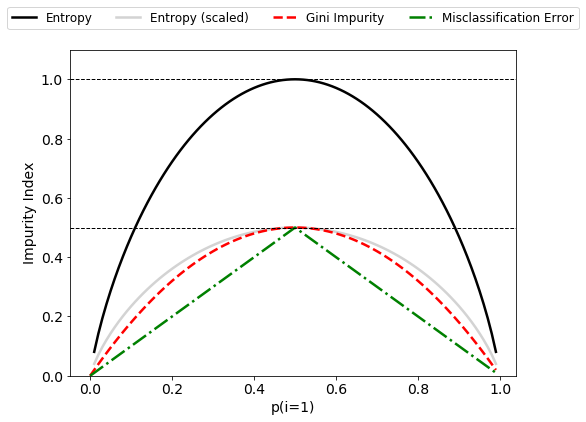

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)','Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2.5, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False, prop={'size': 12})

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.tick_params(labelsize=14)
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)', size = 14)
plt.ylabel('Impurity Index', size = 14)
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

#### Next, I take a closer look at how entropy and gini behave for varying ratios of two classes.

In [27]:
import pandas as pd

x = np.arange(0.05,1,0.05)

scores = pd.DataFrame(
{
    "%Class_A": x,
    "%Class_B": 1 - x,
    "Entropy": [entropy(x) if x != 0 else 0 for x in x],
    "Gini"   : [gini(x) if x != 0 else 0 for x in x],
})

In [28]:
scores

,%Class_A,%Class_B,Entropy,Gini
0,0.05,0.95,0.286397,0.095
1,0.10,0.90,0.468996,0.180
2,0.15,0.85,0.609840,0.255
3,0.20,0.80,0.721928,0.320
4,0.25,0.75,0.811278,0.375
5,0.30,0.70,0.881291,0.420
6,0.35,0.65,0.934068,0.455
7,0.40,0.60,0.970951,0.480
8,0.45,0.55,0.992774,0.495
9,0.50,0.50,1.000000,0.500


No handles with labels found to put in legend.


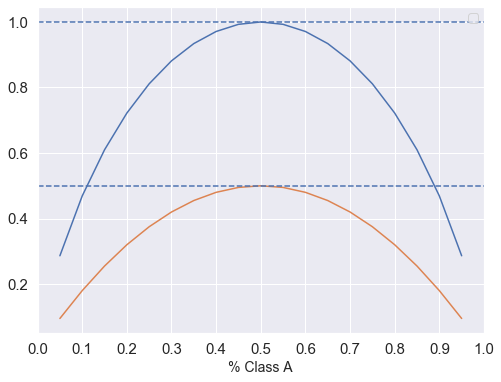

In [29]:
plt.figure(figsize = (8,6))
ax1 = plt.plot(scores['%Class_A'], scores.Entropy)
ax2 = plt.plot(scores['%Class_A'], scores.Gini)
plt.axhline(y = scores.Entropy.max(), linestyle = '--')
plt.axhline(y = scores.Gini.max(), linestyle = '--')
plt.xlabel('% Class A', fontsize = 14)
plt.legend(loc='upper right',fancybox=True, prop={'size': 12})
plt.tick_params(labelsize=15)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

## Now I will build a machine learning algorithm
- I will use sklearn's built-in Iris data set.  I will compare an arbitrary classification rule, calculate the Gini of the resulting subsets to find the "information gained," then compare it to sklearn's model.
- I will start by analyzing the Iris data, then select a subset to work with.

In [30]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('darkgrid')

In [31]:
data = load_iris()
# to view documentaton, try running "print(data.DESCR)" in a cell

In [32]:
# Prepare dataframe from load_iris()

df = pd.DataFrame(data = data.data, columns = data.feature_names)
df['species'] = data.target

def flower_map(x):
    if x == 0:
        return "Setosa"
    elif x == 1:
        return "Versicolour"
    elif x == 2:
        return "Virginica"
    
df['species'] = df['species'].map(flower_map)

In [33]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


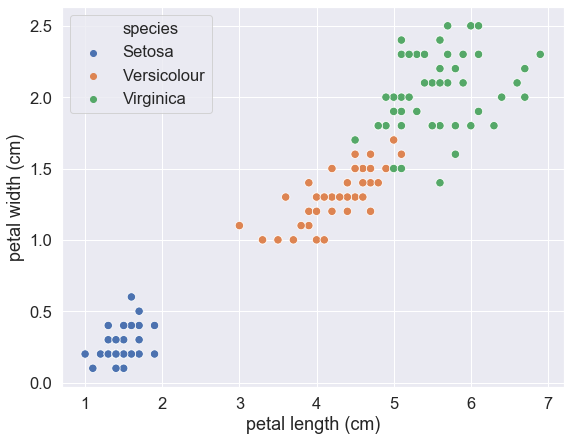

In [34]:
sns.set(font_scale=1.5)
plt.figure(figsize=(9,7))
sns.scatterplot(x = df['petal length (cm)'], y = df['petal width (cm)'],
                hue = df['species'], s = 70)

In [35]:
## Filtering out "Virginica" to just to compare 2 flower types

two_flowers_df = df.loc[df.species != "Virginica", :].copy()
# .copy() means to copy the dataframe

In [36]:
def gini_sum(p_list):
    return np.sum([x * (1 - x) for x in p_list])

In [37]:
two_flowers_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [38]:
two_flowers_df.species.value_counts()

Versicolour    50
Setosa         50
Name: species, dtype: int64

In [39]:
top_leaf = gini_sum([50/100, 50/100])
print("Top Leaf Gini : ", top_leaf, '\n')

## Choosing an arbitrary split based on petal width (see scatter plot above)

# Rule: if 'petal width (cm)' <= 0.2, then it's Setosa else Versicolour

leaf_1 = two_flowers_df.loc[two_flowers_df['petal width (cm)'] <= 0.2, 'species']
leaf_2 = two_flowers_df.loc[two_flowers_df['petal width (cm)'] > 0.2, 'species']

print("Leaf 1 Contents:")
print(leaf_1.value_counts(), '\n')
print("Leaf 2 Contents:")
print(leaf_2.value_counts(), '\n')

leaf_1_gini = gini_sum([34/34])
leaf_2_gini = gini_sum([50/66, 16/60])

leaf_1_wt = 34/100
leaf_2_wt = 66/100

bot_leaf_total = (leaf_1_wt * leaf_1_gini) + (leaf_2_wt * leaf_2_gini)

print("Bottom leaf total Gini : ",  round(bot_leaf_total,4) )
print("Information Gain = ", round(top_leaf - bot_leaf_total,4) )

Top Leaf Gini :  0.5 

Leaf 1 Contents:
Setosa    34
Name: species, dtype: int64 

Leaf 2 Contents:
Versicolour    50
Setosa         16
Name: species, dtype: int64 

Bottom leaf total Gini :  0.2503
Information Gain =  0.2497


![img](example_tree.jpg)

### Using my "rule" :
### If the flower has petal width <= 0.2 cm, label it Setosa.
### If it's petal width is > 0.2 cm, label it as Versocolour.

- I'm getting 84% Accuracy like this, but still mis-classifying 16 flowers as "Verisolor" when they are actually Setosa.
- Now I will compare Sklearn's model, which will automatically pick the best "rules" to split this data to obtain maximum information gain (via gini metric) and make classifications.

In [40]:
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

X = two_flowers_df.loc[:, features]
y = two_flowers_df['species']

dtc_model = DecisionTreeClassifier(random_state = 1)

dtc_model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [41]:
print("Training Accuracy : {}".format( dtc_model.score(X, y) ))

Training Accuracy : 1.0


In [42]:
pd.DataFrame({"feature" : features, "importance" : dtc_model.feature_importances_}).sort_values(by = 'importance')

,feature,importance
0,sepal length (cm),0.0
1,sepal width (cm),0.0
2,petal length (cm),0.0
3,petal width (cm),1.0


In [43]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def Plot_Tree(model, class_names, feature_names):
    dot_data = StringIO() 
    export_graphviz(model, out_file=dot_data,  
                    filled=False, rounded=True,
                    special_characters=True,
                    class_names = class_names,
                    feature_names= feature_names)  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return display(Image(graph.create_png()))

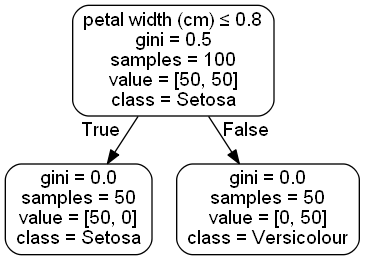

In [44]:
Plot_Tree(dtc_model, class_names = ['Setosa','Versicolour'], feature_names = features)

### Sklearn's Tree got 100% accuracy by usng the adjusted rule of petal width <= 0.8 cm!
-  Check the information gain and see why it figured it out.

In [45]:
leaf_1 = two_flowers_df.loc[two_flowers_df['petal width (cm)'] <= 0.8, 'species']
leaf_2 = two_flowers_df.loc[two_flowers_df['petal width (cm)'] > 0.8, 'species']
print("Leaf 1 rows : ", leaf_1.shape[0])
print("Leaf 2 rows : ", leaf_2.shape[0])

top_leaf = gini_sum([50/100, 50/100])
print("Top Leaf Gini : ", top_leaf)

print(leaf_1.value_counts())
print(' ')
print(leaf_2.value_counts())

bot_leaf = 50/100 * gini_sum([50/50]) + 50/100 * gini_sum([50/50, 50/50])

print("Next leaf total Gini : ",  round(bot_leaf,2) )
print("\nInformation Gain = ", round(top_leaf - bot_leaf, 2) )

Leaf 1 rows :  50
Leaf 2 rows :  50
Top Leaf Gini :  0.5
Setosa    50
Name: species, dtype: int64
 
Versicolour    50
Name: species, dtype: int64
Next leaf total Gini :  0.0

Information Gain =  0.5


### "Petal width <= 0.2 cm" rule yielded Information Gain =  0.2497
### "Petal width <= 0.8 cm" rule gave more information gain (0.5)

* This is how the Decision Tree how determines the best splits.  It'll randomly split data one feature at a time and pick the "rules" that result in the highest information gain (which comes from leaf compositions with the highest gini or entropy).
* The Decision Tree will continue splitting the data into subsets until the leaves have the highest purity possible OR until it reaches a specified maximum depth or number of leaf nodes.

### Below I will run this algorithm again, but using all three flowers and allowing the tree to split leaves until completion.

In [46]:
df.species.value_counts()

Versicolour    50
Setosa         50
Virginica      50
Name: species, dtype: int64

Training Accuracy : 1.0
Testing Accuracy : 0.9555555555555556


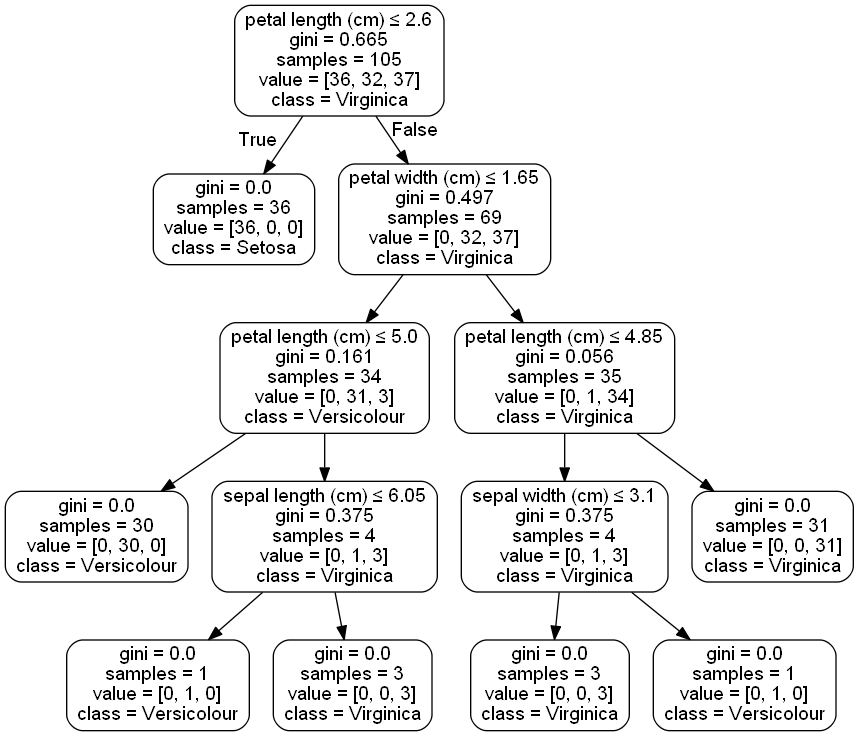

In [47]:
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

X = df.loc[:, features]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

dtc_model = DecisionTreeClassifier()

dtc_model.fit(X_train, y_train)

print("Training Accuracy : {}".format( dtc_model.score(X_train, y_train) ))
print("Testing Accuracy : {}".format( dtc_model.score(X_test , y_test ) ))

Plot_Tree(dtc_model, class_names = ['Setosa','Versicolour', 'Virginica'], feature_names = features)

### Pros:
- Computationally quick compared to Linear models
- Non-parametric (more suited for working with non-linear data)
- "White Box" approach (results and methods are easy to interpret)
- Handles multi-colinearity well since it only considers one variable at a time.

### Cons:
- "Greedy" algorithm, will continue splitting until it "learns" the data set.  Very prone to over-fitting since it favors making "locally optimal" decisions.
- high variance, small changes in the data set can result in a very different tree of "rules".
- Powerful alogrithm, but often requires ensembling (ie Random Forest) to really be useful, which can become computationally expensive.

Measure           | What it does
------------------|-------------
max_depth         | How many splits / "rules" will my tree be allowed to do? (maximum nodes)
criterion         | The "loss" function to train my tree on (can be entropy, gini, etc).
max_features      | The limit to how many features my tree can use.
max_leaf_nodes    | The limit of how many leaves each split can produce.
min_samples_leaf  | The minimum number of samples required to produce a leaf. 
min_samples_split | Number of samples required in the lead before splitting.

In [48]:
dc = DecisionTreeClassifier()

params = {
    
    "max_depth"        : [1,2,3,4,5,10],
    "criterion"        : ['entropy', 'gini'],
    "max_features"     : [0.5, 1],
    "max_leaf_nodes"   : [2,3,5],
    'min_samples_leaf': [2,3,5],
    'min_samples_split' : [2,3,5]
}

gs = GridSearchCV(dc, params, cv = 3)

gs.fit(X_train, y_train)

print("Training Accuracy : {}".format( gs.score(X_train, y_train) ))
print("Testing Accuracy : {}".format( gs.score(X_test , y_test ) ))

Training Accuracy : 0.8952380952380953
Testing Accuracy : 0.8666666666666667


c:\users\ryana\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 0.5,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

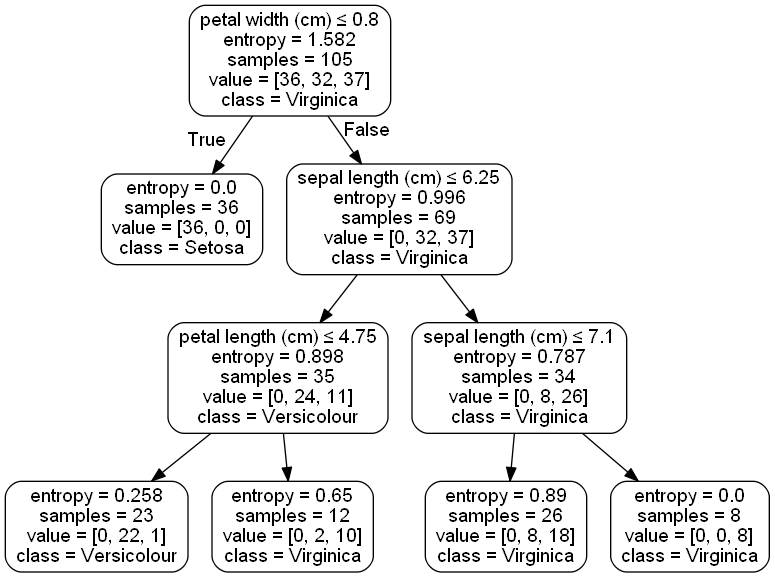

In [50]:
Plot_Tree(gs.best_estimator_, class_names = ['Setosa','Versicolour', 'Virginica'], feature_names = features)

In [26]:
# Commands for troubleshooting tree diagrams:

# pip install pydotplus

# pip install graphviz

# pip3 install pyparsing

#### installing via homebrew for MacOS, requires homebrew at https://brew.sh
# brew install graphviz